In [2]:
import numpy as np

# 평균 제곱 오차
def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)

t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]

print(mean_squared_error(np.array(y), np.array(t)))

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print(mean_squared_error(np.array(y), np.array(t)))

# 평균제곱 오차를 기준으로 첫번째가 정답에 더 가까울 것으로 판단할 수 있다.

0.0975
0.5975


In [5]:
# 교차 엔트로피 오차
def cross_entropy_error(y, t):
    delta = 1e-7 # log(x) 에서 x 가 0이면 무한대를 출력하므로 작은값인 델타를 더해준다
    return -np.sum(t*np.log(y+delta))


t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
print(cross_entropy_error(np.array(y), np.array(t)))

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print(cross_entropy_error(np.array(y), np.array(t)))

0.510825457099
2.30258409299


In [7]:
# 미니 배치 : 데이터 중 일부를 추려 전체의 '근사치 로 이용

import sys, os

sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)  # 무작위 10개 빼내기

# 배치용 교차 엔트로피 오차
def batch_cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

# 신경망을 학습할때 정확도를 지표로 삼아서는 안된다. 정확도를 지표로 하면 매개변수의 미분이 대부분의 장소에서 0이 되기 때문이다.
# 계단 함수는 한순간만 변화를 일으키지만, 시그모이드 함수의 미분은 연속적으로 변한다 (어느 장소도 0이 되지 않는다.)

(60000, 784)
(60000, 10)


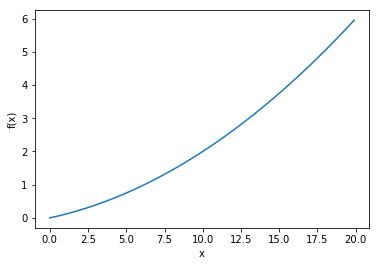

1.9999999999908982e-09


In [20]:
# 수치 미분

def numerical_diff(f, x):
    h = 1e-4
    return (f(x + h) - f(x - h)) / 2 * h

def function_1(x):
    return 0.01 * x ** 2 + 0.1 * x

import matplotlib.pylab as plt

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

print(numerical_diff(function_1, 5))


/Users/junyoung/Frameworks/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


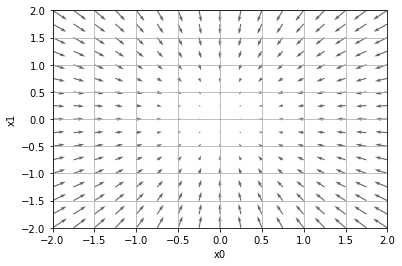

In [38]:
# 기울기
# 여러 변수 중 목표 변수 하나에 초점을 맞추고 다른 변수는 고정해야 했지만 동시에 계산하고 싶다면?
# 모든 변수의 편미분을 벡터로 정리한 것을 기울기라고 함

def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 値を元に戻す

    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)

        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)

        return grad

def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)
    
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]))

plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1], angles="xy", color="#666666")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.legend()
plt.draw()
plt.show()


In [44]:
# 경사 하강법

def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

def function_2(x):
    return x[0] ** 2 + x[1] ** 2

init_x = np.array([-3.0, 4.0])
# 가장 낮은 장소인 원점에 점점 가까워진다.
print(gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100))

# 학습률이 너무 큰 예
print(gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100))

# 학습률이 너무 작은 예
print(gradient_descent(function_2, init_x=init_x, lr=0.00000000000001, step_num=100))


[ -6.11110793e-10   8.14814391e-10]
[  2.34235971e+12  -3.96091057e+12]
[  2.34235971e+12  -3.96091057e+12]
